In [1]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from sklearn.metrics import accuracy_score, classification_report, f1_score
import matplotlib.pyplot as plt
from PIL import Image
import random

# 1. Device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Evaluating on device: {device}")

Evaluating on device: mps


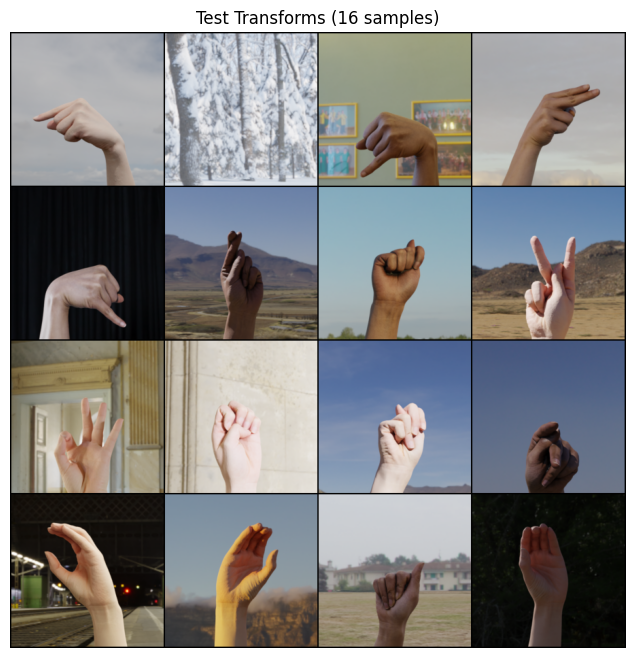

In [2]:
test_transform = transforms.Compose([
    transforms.Resize(250),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# 3. Load the test dataset (no transform for sampling paths)
test_dir = "data/synthetic_test_old"
dataset = datasets.ImageFolder(root=test_dir, transform=None)
classes = dataset.classes
paths = [path for path, _ in dataset.samples]

# 4. Sample a few images
sample_paths = random.sample(paths, 16)  # 16 random images for visualization

# 5. Apply test transforms
tensors = []
for p in sample_paths:
    img = Image.open(p).convert('RGB')
    t = test_transform(img)
    tensors.append(t)
batch = torch.stack(tensors)

# 6. Denormalize for display
inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
    std=[1 / s for s in [0.229, 0.224, 0.225]]
)
batch = inv_normalize(batch)

# 7. Create a grid and plot
grid = utils.make_grid(batch, nrow=4, padding=2)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
plt.title('Test Transforms (16 samples)')
plt.show()

In [3]:
from sklearn.metrics import f1_score

test_dir = "data/synthetic_test_old"
test_ds = datasets.ImageFolder(root=test_dir, transform=test_transform)
test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=False
)

model_path = "resnet18_weight_reg_no_aug_bestlr2_wd4.pth"
model_path = "final.pth"
model = torch.load(model_path, map_location=device, weights_only=False)
model.eval()

# 6. Inference loop
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(labels.tolist())

# 7. Metrics
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"Test Accuracy: {acc * 100:.2f}%\n")
print(f"Test F1: {f1 * 100:.2f}%\n")
print("Classification Report:")
present_labels = sorted(set(all_labels))

# 2. Map those indices to their names
present_names = [test_ds.classes[i] for i in present_labels]

# 3. Call classification_report with explicit labels & names
print("Classes in test set:", present_labels)
print("Names of those classes:", present_names)
print("\nClassification Report for present classes:\n")
print(classification_report(
    all_labels,
    all_preds,
    labels=present_labels,
    target_names=present_names,
    digits=4
))


Test Accuracy: 28.30%

Test F1: 23.38%

Classification Report:
Classes in test set: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
Names of those classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing']

Classification Report for present classes:

              precision    recall  f1-score   support

           A     0.4435    0.5100    0.4744       100
           B     0.5467    0.8200    0.6560       100
           C     0.2340    0.1100    0.1497       100
           D     0.3000    0.2100    0.2471       100
           E     0.3788    0.5000    0.4310       100
           F     0.1944    0.2100    0.2019       100
           G     0.0741    0.0200    0.0315       100
           H     0.2985    0.2000    0.2395       100
           I     0.2067    0.3100    0.2480       100
           J     0.0000    0.0000    0.0000       100
           

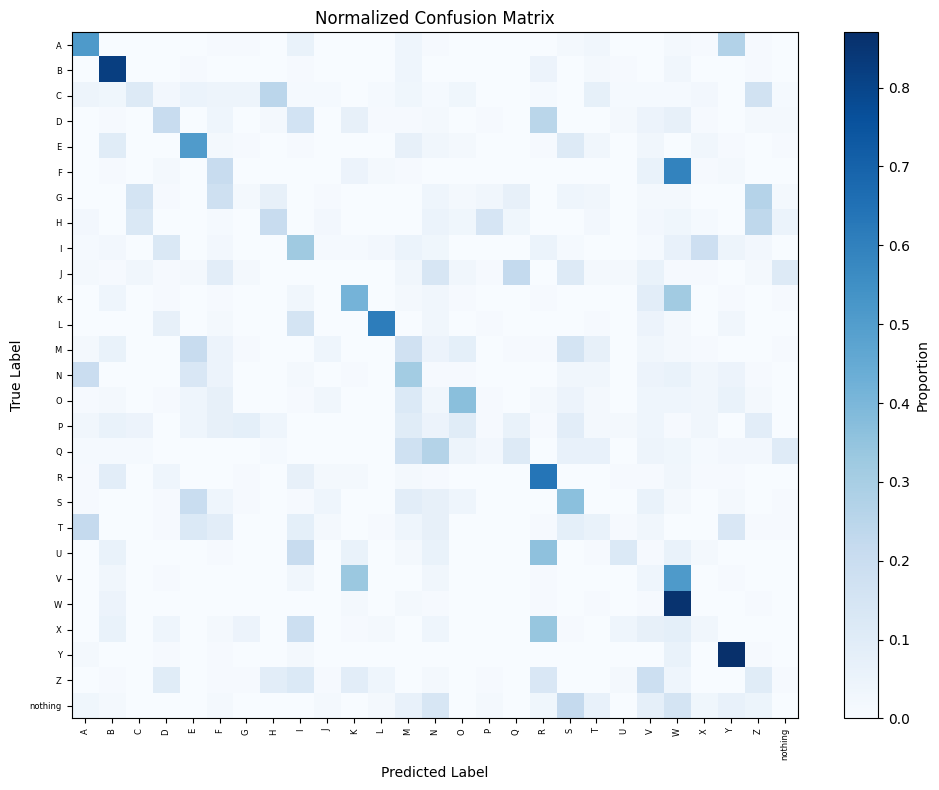

In [4]:
import numpy as np
from sklearn.metrics import confusion_matrix

present_labels = sorted(set(all_labels))
present_names = [test_ds.classes[i] for i in present_labels]

# 2. Compute the raw confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=present_labels)

# 3. Normalize by true‐class counts (so rows sum to 1)
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# 4. Plot it
plt.figure(figsize=(10, 8))
plt.imshow(cm_norm, interpolation='nearest', aspect='auto', cmap='Blues')
plt.title('Normalized Confusion Matrix')
plt.colorbar(label='Proportion')

tick_marks = np.arange(len(present_labels))
plt.xticks(tick_marks, present_names, rotation=90, fontsize=6)
plt.yticks(tick_marks, present_names, fontsize=6)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()